# Object-based filtering of pixel classifications <img align="right" src="../../Supplementary_data/dea_logo.jpg">

* [**Sign up to the DEA Sandbox**](https://docs.dea.ga.gov.au/setup/sandbox.html) to run this notebook interactively from a browser
* **Compatibility:** Notebook currently compatible with the `DEA Sandbox` environment


## Background

Geographic Object-Based Image Analysis (GEOBIA), aims to group pixels together into meaningful image-objects. There are two advantages to a GEOBIA workflow: one, we can reduce the 'salt and pepper' effect typical of classifying pixels; and two, we can increase the computational efficiency of our workflow by grouping pixels into fewer, larger, but more meaningful objects. A review of the emerging trends in GEOBIA can be found in [Chen et al. (2017)](https://www.tandfonline.com/doi/abs/10.1080/15481603.2018.1426092).

## Description

In this notebook, we take the pixel-based classifications generated in the `4_Classify_satellite_data.ipynb` notebook, and filter the classifications by image-objects. To do this, we first need to conduct image segmentation using the function `skimage.segmentation.quickshift`. The image segmentation is conducted on the NDVI layer output in the previous notebook. To filter the pixel observations, we assign to each segment the majority (mode) pixel classification using the scipy.ndimage.measurements import _stats module.

1. Run the image segmentation
2. Visualize the segments
3. Calculate the mode statistic for each segment
4. Write the new object-based classification to disk as a COG
5. Plot the result


***
## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load Packages

In [1]:
import scipy
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from datacube.utils.cog import write_cog
from scipy.ndimage._measurements import _stats
from skimage.segmentation import quickshift

## Analysis Parameters

* `pred_tif`: The path and name of the prediction GeoTIFF output in the previous notebook.
* `tif_to_seg`: The geotiff to use as an input to the image segmentation, in the default example this was an NDVI layer output in the last notebook.
* `results`: A folder location to store the classified GeoTIFFs.

In [2]:
pred_tif = 'results/prediction.tif'

tif_to_seg = 'results/NDVI.tif'

results = 'results/'

## Generate an object-based classification

### Run image segmentation

In [3]:
# Convert our mean NDVI xarray into a numpy array
ndvi = xr.open_rasterio(tif_to_seg).squeeze().values

# Calculate the segments
segments = quickshift(ndvi,
                      kernel_size=2,
                      convert2lab=False,
                      max_dist=6,
                      ratio=1.0)

/tmp/ipykernel_3202/2571898095.py:2: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  ndvi = xr.open_rasterio(tif_to_seg).squeeze().values


### Visualise segments

To help us visualize the segments, we can calculate the zonal mean NDVI for each segment and then we'll plot a zoomed in section of the region

In [4]:
segments_zonal_mean_qs = scipy.ndimage.mean(input=ndvi,
                                            labels=segments,
                                            index=segments)

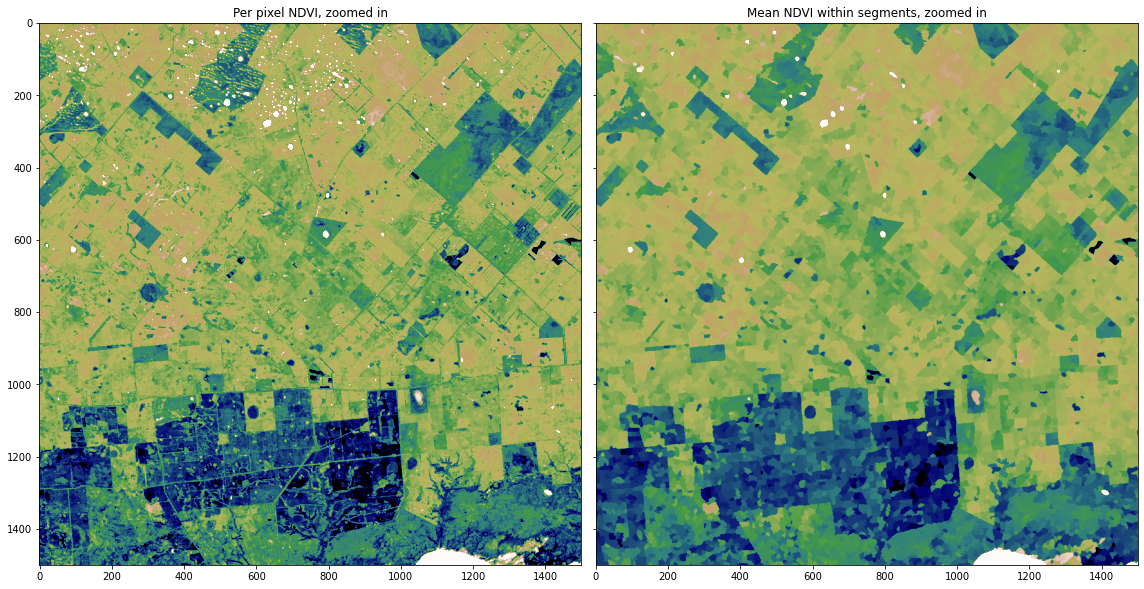

In [5]:
fig,ax=plt.subplots(1,2, figsize=(16,8), sharey=True)
ax[0].imshow(ndvi[1000:2500,1000:2500], cmap='gist_earth_r', vmin=0.1, vmax=0.7)
ax[1].imshow(segments_zonal_mean_qs[1000:2500,1000:2500], cmap='gist_earth_r', vmin=0.1, vmax=0.7)
ax[0].set_title('Per pixel NDVI, zoomed in');
ax[1].set_title('Mean NDVI within segments, zoomed in')
plt.tight_layout();

### Open pixel-based predictions

In [6]:
pred = xr.open_rasterio(pred_tif).squeeze().drop_vars('band')

/tmp/ipykernel_3202/920710520.py:1: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  pred = xr.open_rasterio(pred_tif).squeeze().drop_vars('band')


### Calculate mode

Within each segment, the majority classification is calculated and assigned to that segment.

In [7]:
count, _sum =_stats(pred, labels=segments, index=segments)
mode = _sum > (count/2)
mode = xr.DataArray(mode,  coords=pred.coords, dims=pred.dims, attrs=pred.attrs).astype(np.int16)

### Write result to disk

In [8]:
write_cog(mode, results+ 'prediction_object.tif', overwrite=True)

/env/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


PosixPath('results/prediction_object.tif')

### Plot result

Below we plot the the pixel-based classification alongside the newly created object-based classification. You can see the 'salt and pepper' effect of individual pixels being classified as crop has been removed in the object based classification, resulting in a 'cleaner' classification. 

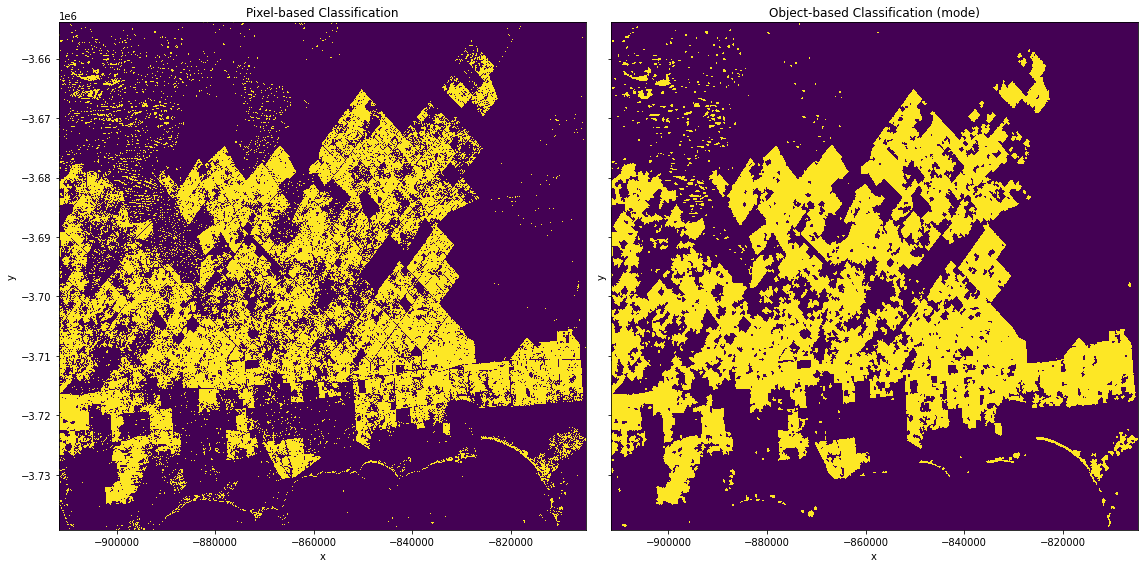

In [9]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(16, 8))
pred.plot(ax=axes[0], add_colorbar=False)
mode.plot(ax=axes[1], add_colorbar=False)
axes[0].set_title('Pixel-based Classification')
axes[1].set_title('Object-based Classification (mode)')
plt.tight_layout()

## Recommended next steps

This is the last notebook in the `Scalable Machine Learning on the ODC` workflow! To revist any of the other notebooks, use the links below.

1. [Extracting training data from the ODC](1_Extract_training_data.ipynb) 
2. [Inspecting training data](2_Inspect_training_data.ipynb)
3. [Evaluate, optimize, and fit a classifier](3_Evaluate_optimize_fit_classifier.ipynb)
4. [Classifying satellite data](4_Classify_satellite_data.ipynb)
5. **Object-based filtering of pixel classifications (this notebook)**



***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** March 2022


## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)